# 1. Define genetic algorithm suite

In [1]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

from src.prediction.gpr_model_trainer import GPRModelTrainer
from src.prediction.etr_model_trainer import EtrModelTrainer

from src.ga.chromosome.vent_hole import VentHole

from src.ga.gene.shape.shape_variations import (
    circle_params,
    donut_params,
    hole_params,
    trapezoid_params,
    triangle_params,
    wing_params,
)
from src.ga.gene.pattern.pattern_variations import (
    circular_params,
    corn_params,
    grid_params,
)

from src.ga.ga_pipeline import GAPipeline

from src.ga.p1_initialize.init_vent import VentInitializer
from src.ga.p2_fitness.vent_fitness import Criterion, VentFitnessCalculator
from src.ga.p3_select.behaviors import (
    TournamentSelectionFilter,
    ElitismSelectionFilter,
    RouletteWheelSelectionFilter,
)
from src.ga.p4_crossover.behaviors import (
    OnePointCrossover,
    TwoPointCrossover,
    UniformCrossover,
)

# ----------------- Define the GA CONSTANTS -----------------
# 1. Define the criteria weights, w1, w2, w3
CRITERIA_WEIGHT = (1.2, 1, 0.8)

# 2. Define the criteria with direction, min, and max values
DRAG_CRITERION: Criterion = ("lower", 0.2, 0.3)  # Lower is better, range 0.2 to 0.3
DRAG_STD_CRITERION: Criterion = ("lower", 0, 0.05)  # Lower is better, range 0 to 0.05

AVG_TEMP_CRITERION: Criterion = (
    "lower",
    250,
    450,
)  # Lower is better, range 250K to 400K
AVG_TEMP_STD_CRITERION: Criterion = ("lower", 0, 10)  # Lower is better, range 0K to 10K

MAX_TEMP_CRITERION: Criterion = (
    "lower",
    300,
    500,
)  # Lower is better, range 300K to 500K
MAX_TEMP_STD_CRITERION: Criterion = ("lower", 0, 10)  # Lower is better, range 0K to 10K

# 3. Define the grid parameters
GRID_SCALE = 1
# Scaling factor

GRID_RESOLUTION = 2
# Grid resolution

GRID_WIDTH = 60
# Grid width, ~= canvas size

GRID_BOUND = (
    (-GRID_WIDTH / 2, GRID_WIDTH / 2),
    (-GRID_WIDTH / 2, GRID_WIDTH / 2),
)
# ----------------- Define the GA MODELS -----------------

gpr_kernel = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-2, 1e2))
gpr_model_trainer = GPRModelTrainer(
    gpr_kernel=gpr_kernel,
    gpr_drag_config=(10, 1e-5),
    gpr_max_temp_config=(10, 1e-3),
    gpr_avg_temp_config=(10, 1e-3),
    grid_bound=GRID_BOUND,
    grid_bound_width=GRID_WIDTH,
    grid_resolution=GRID_RESOLUTION,
    grid_scale=GRID_SCALE,
    desired_variance=0.9,
)

etr_model_trainer = EtrModelTrainer(
    etr_drag_config=(100, 42),
    etr_max_temp_config=(100, 42),
    etr_avg_temp_config=(100, 42),
    grid_bound=GRID_BOUND,
    grid_bound_width=GRID_WIDTH,
    grid_resolution=GRID_RESOLUTION,
    grid_scale=GRID_SCALE,
    desired_variance=0.9,
)

# ----------------- Define the GA PIPELINES -----------------
suite = GAPipeline[VentHole](
    suite_name="exp/tournament/config",
    suite_max_count=50,
    suite_min_population=20,
    suite_min_chromosome=40,
    crossover_behavior=UniformCrossover(),
    selector_behavior=TournamentSelectionFilter(tournament_size=4),
    fitness_calculator=VentFitnessCalculator(
        model_trainer_tuple=(
            etr_model_trainer,
            gpr_model_trainer,            
            etr_model_trainer,
        ),
        criteria_weight_list=CRITERIA_WEIGHT,
        drag_criterion=DRAG_CRITERION,
        drag_std_criterion=DRAG_STD_CRITERION,
        avg_temp_criterion=AVG_TEMP_CRITERION,
        avg_temp_std_criterion=AVG_TEMP_STD_CRITERION,
        max_temp_criterion=MAX_TEMP_CRITERION,
        max_temp_std_criterion=MAX_TEMP_STD_CRITERION,
    ),
    immediate_exit_condition=lambda x: x[0] >= 0.725 and x[1] >= 0.725,
    mutation_probability=0.01,
    population_initializer=VentInitializer(
        population_size=200,
        grid_scale=GRID_SCALE,
        grid_resolution=GRID_RESOLUTION,
        pattern_bound=GRID_BOUND,
        pattern_gene_pool=[circular_params, corn_params, grid_params],
        shape_gene_pool=[
            circle_params,
        ],
    ),
)

[Storage]: JSON data loaded from /Users/june/Documents/project/cau/4_1/capstone_1_update/store/gene_parameters.json
[Storage]: JSON data loaded from /Users/june/Documents/project/cau/4_1/capstone_1_update/store/gene_parameters.json
[StochasticStorage]: JSON data loaded from /Users/june/Documents/project/cau/4_1/capstone_1_update/store/shape_gene_pdf.json
[StochasticStorage]: JSON data loaded from /Users/june/Documents/project/cau/4_1/capstone_1_update/store/shape_gene_pdf.json
[StochasticStorage]: JSON data loaded from /Users/june/Documents/project/cau/4_1/capstone_1_update/store/shape_gene_pdf.json
[StochasticStorage]: JSON data loaded from /Users/june/Documents/project/cau/4_1/capstone_1_update/store/pattern_gene_pdf.json
[StochasticStorage]: JSON data loaded from /Users/june/Documents/project/cau/4_1/capstone_1_update/store/pattern_gene_pdf.json
[StochasticStorage]: JSON data loaded from /Users/june/Documents/project/cau/4_1/capstone_1_update/store/pattern_gene_pdf.json
------------

/Users/june/Documents/project/cau/4_1/capstone_1_update/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/june/Documents/project/cau/4_1/capstone_1_update/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/june/Documents/project/cau/4_1/capstone_1_update/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and c

-----------------------------------------------
| [ModelTrainer]: Training set found, loading |
-----------------------------------------------
----------------------------------------------------
| [ModelTrainer]: PCA optimal founding initialized |
----------------------------------------------------
--------------------------------------------------------------------------------
| [ModelTrainer]: Optimal feature count founded: 107 for desired variance: 0.9 |
--------------------------------------------------------------------------------
-----------------------------------------------
| [ModelTrainer]: Training set found, loading |
-----------------------------------------------
-----------------------------------------------
| [ModelTrainer]: Training set found, loading |
-----------------------------------------------
----------------------------------------------------
| [ModelTrainer]: PCA optimal founding initialized |
----------------------------------------------------
-------

# 2. Run genetic algorithm

매번 run을 실행할 때마다, 개체 수, 격자 해상도 등에 따라 다르지만, **수행 시간이 길 수 있습니다.**

In [2]:
suite.run()

----------------------------------------------------------------------------------------------------
>> GA started
----------------------------------------------------------------------------------------------------
Suite_name: exp/tournament/config
Suite_max_count: 50
Suite_min_population: 20
Suite_min_chromosome: 40
Immediate_exit: False
Generation: 0
Initial_population: 200
Population_count: 0
Unique_population_count: 0
Mutation_count: 0
Mutation_probability: 0.01
Fitness_calculator: GPR
Selector_behavior: TournamentSelection
Crossover_behavior: Uniform Crossover
Population_initializer: VentInitializer
----------------------------------------------------------------------------------------------------
[StochasticStorage]: JSON data saved to /Users/june/Documents/project/cau/4_1/capstone_1_update/store/exp/tournament/config/fitness_evolution.json
[StochasticStorage]: JSON data saved to /Users/june/Documents/project/cau/4_1/capstone_1_update/store/exp/tournament/config/biased_fitness_

# 3. Plot fitness result

- `biased_fitness`: 가중치가 적용된 fitness, $w1 * p1 + w2 * p2+ ...$
- `fitness`: 가중치 없이 계산된 fitness, $p1 + p2 + ...$

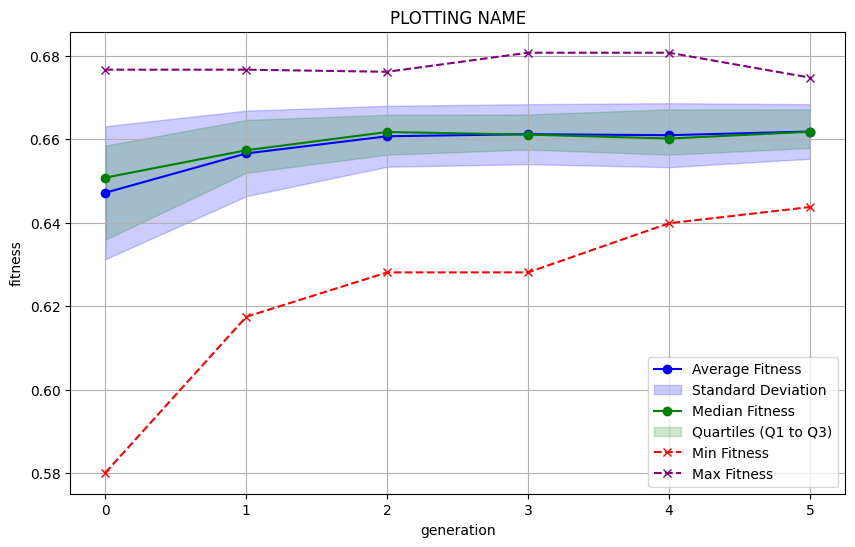

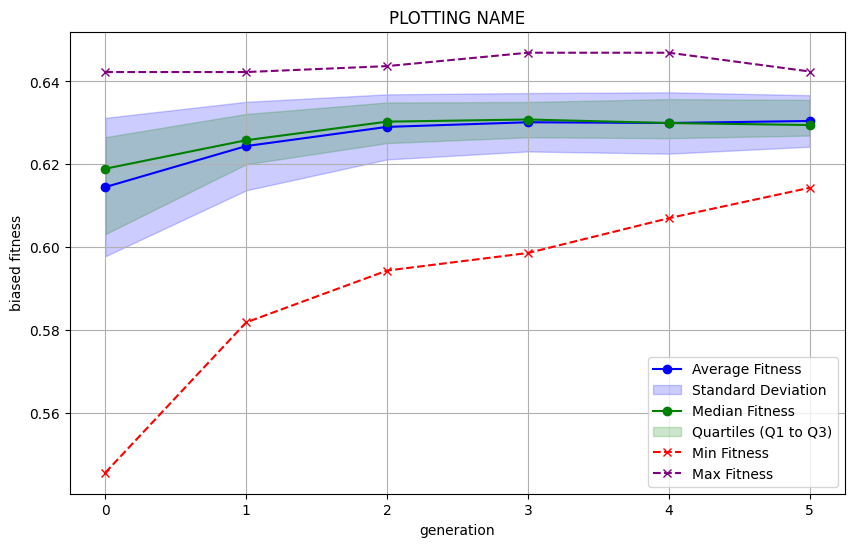

In [3]:
suite.evolution_storage.plot_fitness(
    storage="fitness",
    title="PLOTTING NAME",
    xlabel="generation",
    ylabel="fitness",
)
suite.evolution_storage.plot_fitness(
    storage="biased_fitness",
    title="PLOTTING NAME",
    xlabel="generation",
    ylabel="biased fitness",
)

# 4. Analyze final population(unique)

1. population은 최종 선택된 개체만 남게 됩니다.
2. `population[i]`는 각 VentHole 유전자(Chromosome)이 도출됩니다.
3. `population[i].pattern_matrix` 에는 pattern에 격자화된 point vector가 존재합니다.
3. `population[i].gene_tuple` 을 통해 최종적인 유전자에 접근할 수 있습니다.


--------------------------------------------------
label: VentHole Chromosome_119: ['CircleShape_169', 'CornerTransformation_66']
predict: (0.2946430429111193, 373.2288878999999, 455.1313218999998)
biased_fitness: 0.6276137579665694, fitness: 0.6617685218888082
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


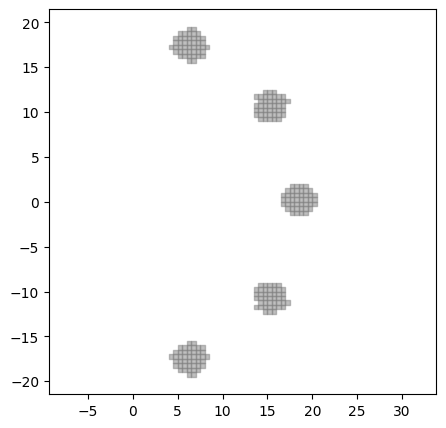

--------------------------------------------------
label: VentHole Chromosome_66: ['CircleShape_36', 'CornerTransformation_64']
predict: (0.2935117869106374, 373.8838283999999, 457.2939884)
biased_fitness: 0.6292634614723516, fitness: 0.6589930468936264
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 7.176097969769296, phi: 0.40092561775804525, rot_count: 4.0, ]


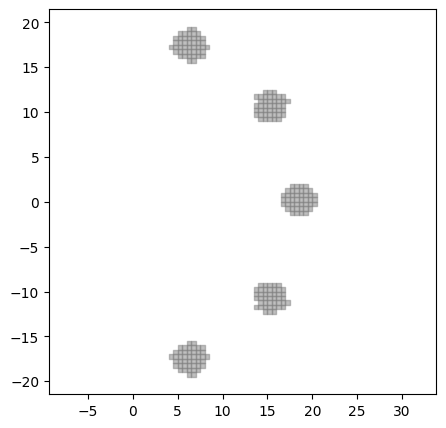

--------------------------------------------------
label: VentHole Chromosome_36: ['CircleShape_66', 'CornerTransformation_169']
predict: (0.2935117869106374, 373.8838283999999, 457.2939884)
biased_fitness: 0.6292634614723516, fitness: 0.6589930468936264
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


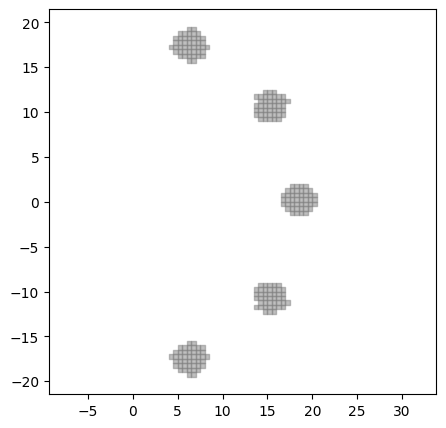

--------------------------------------------------
label: VentHole Chromosome_169: ['CircleShape_80', 'CornerTransformation_36']
predict: (0.2944838003733754, 373.23322989999986, 455.5978704999997)
biased_fitness: 0.6276367640194969, fitness: 0.661006494266248
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


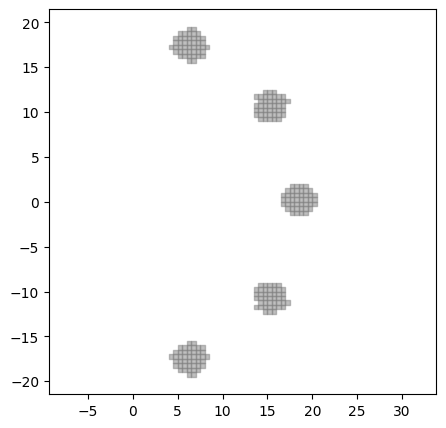

--------------------------------------------------
label: VentHole Chromosome_80: ['CircleShape_169', 'CornerTransformation_66']
predict: (0.2945875362155592, 373.9060512999999, 456.6251782999999)
biased_fitness: 0.6189185957132901, fitness: 0.6514684898444086
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 7.176097969769296, phi: 0.40092561775804525, rot_count: 4.0, ]


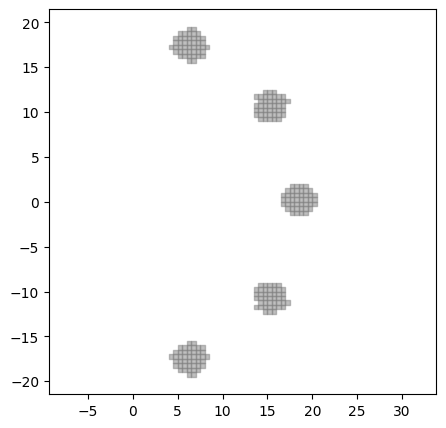

--------------------------------------------------
label: VentHole Chromosome_80: ['CircleShape_169', 'CornerTransformation_80']
predict: (0.29359080928238646, 373.7812461999999, 455.75454869999993)
biased_fitness: 0.6349858628113633, fitness: 0.6664129326761362
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 7.176097969769296, phi: 0.40092561775804525, rot_count: 4.0, ]


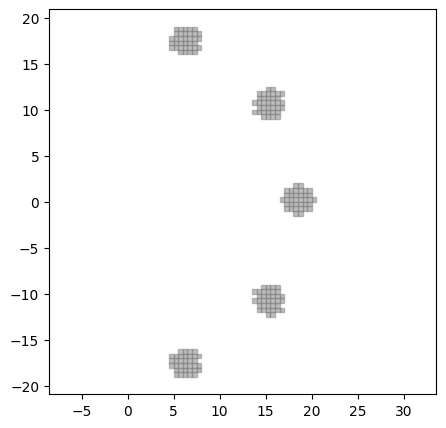

--------------------------------------------------
label: VentHole Chromosome_163: ['CircleShape_169', 'CornerTransformation_25']
predict: (0.29396814224045187, 373.79516429999984, 454.82562349999984)
biased_fitness: 0.6341039776145789, fitness: 0.6672146385954828
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


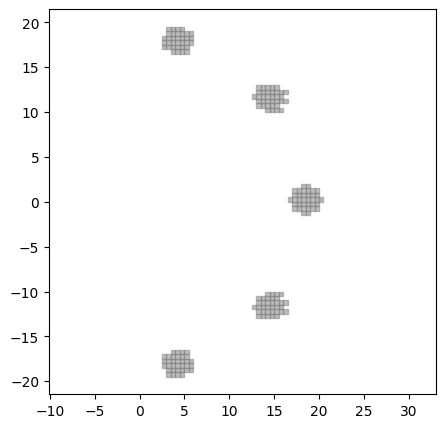

--------------------------------------------------
label: VentHole Chromosome_169: ['CircleShape_66', 'CornerTransformation_163']
predict: (0.2937251216042045, 374.1338844000001, 456.1686619)
biased_fitness: 0.6299544711495453, fitness: 0.6612360524579542
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 2.0, ]


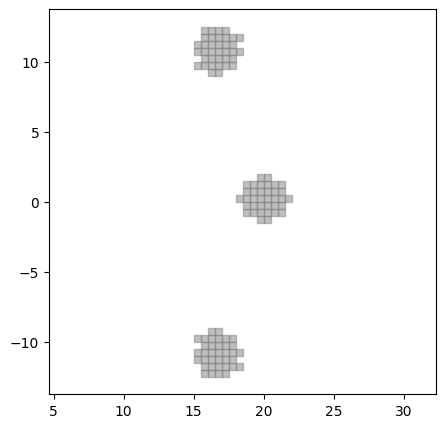

--------------------------------------------------
label: VentHole Chromosome_80: ['CircleShape_66', 'CornerTransformation_74']
predict: (0.2931516173549358, 373.8038568, 456.85730679999983)
biased_fitness: 0.6357320805407711, fitness: 0.6651780084506429
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 7.176097969769296, phi: 0.40092561775804525, rot_count: 4.0, ]


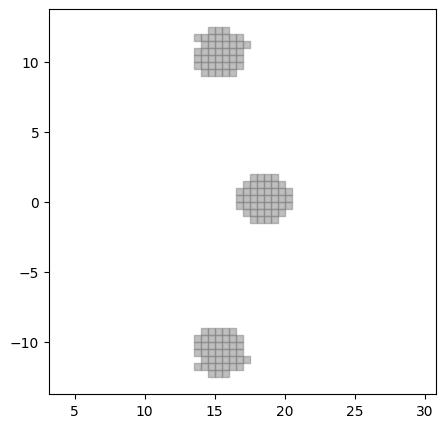

--------------------------------------------------
label: VentHole Chromosome_66: ['CircleShape_36', 'CornerTransformation_147']
predict: (0.2938867739319073, 374.1745135000001, 455.9719017999999)
biased_fitness: 0.628598538117112, fitness: 0.6604001841809267
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


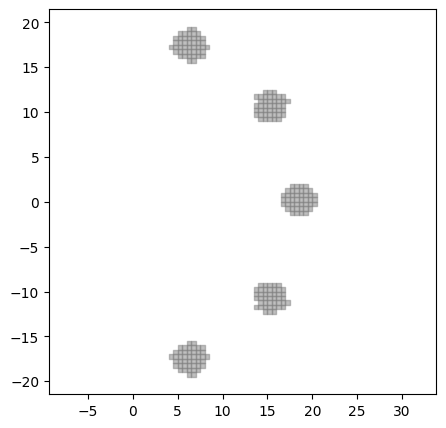

--------------------------------------------------
label: VentHole Chromosome_169: ['CircleShape_66', 'CornerTransformation_66']
predict: (0.2935117869106374, 373.8838283999999, 457.2939884)
biased_fitness: 0.6292634614723516, fitness: 0.6589930468936264
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


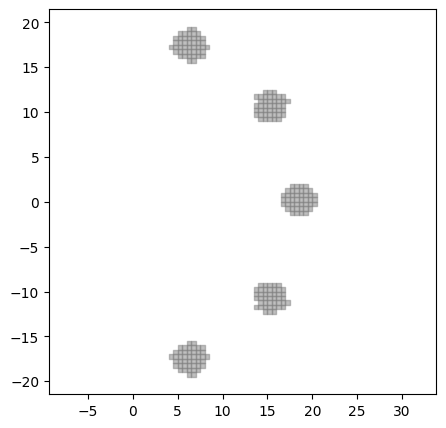

--------------------------------------------------
label: VentHole Chromosome_74: ['CircleShape_74', 'CornerTransformation_25']
predict: (0.2941812748282029, 373.06948679999994, 454.73235619999986)
biased_fitness: 0.6355478432615661, fitness: 0.669178036717972
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


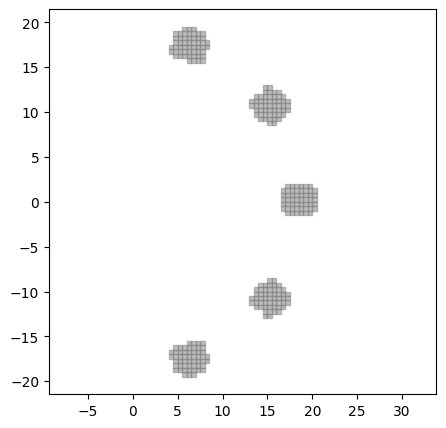

--------------------------------------------------
label: VentHole Chromosome_74: ['CircleShape_25', 'CornerTransformation_80']
predict: (0.29396814224045187, 373.79516429999984, 454.82562349999984)
biased_fitness: 0.6341039776145789, fitness: 0.6672146385954828
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 7.176097969769296, phi: 0.40092561775804525, rot_count: 4.0, ]


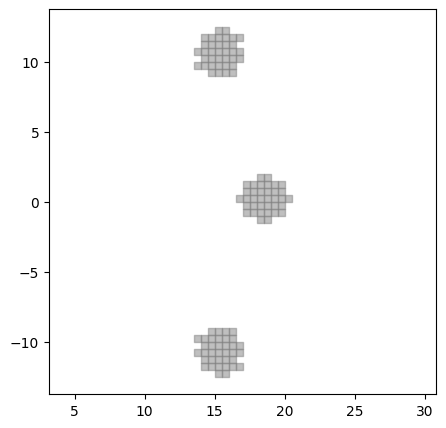

--------------------------------------------------
label: VentHole Chromosome_36: ['CircleShape_80', 'CornerTransformation_169']
predict: (0.2935991585561768, 373.90455410000004, 457.6418842)
biased_fitness: 0.6267197900258782, fitness: 0.6562762229382318
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


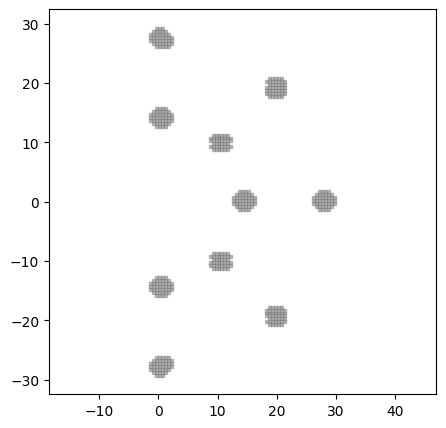

--------------------------------------------------
label: VentHole Chromosome_119: ['CircleShape_36', 'CornerTransformation_66']
predict: (0.2935117869106374, 373.8838283999999, 457.2939884)
biased_fitness: 0.6292634614723516, fitness: 0.6589930468936264
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


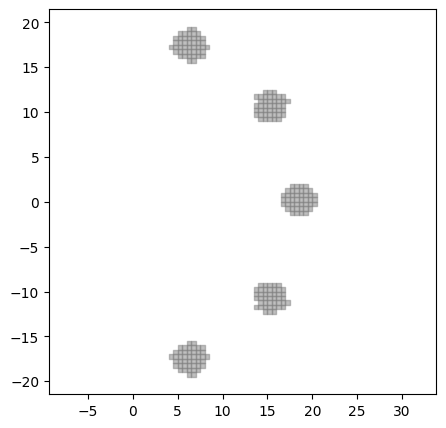

--------------------------------------------------
label: VentHole Chromosome_66: ['CircleShape_119', 'CornerTransformation_119']
predict: (0.2935117869106374, 373.8838283999999, 457.2939884)
biased_fitness: 0.6292634614723516, fitness: 0.6589930468936264
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


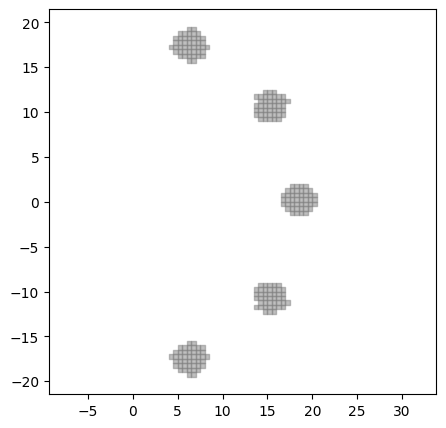

--------------------------------------------------
label: VentHole Chromosome_169: ['CircleShape_66', 'CornerTransformation_169']
predict: (0.2935117869106374, 373.8838283999999, 457.2939884)
biased_fitness: 0.6292634614723516, fitness: 0.6589930468936264
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


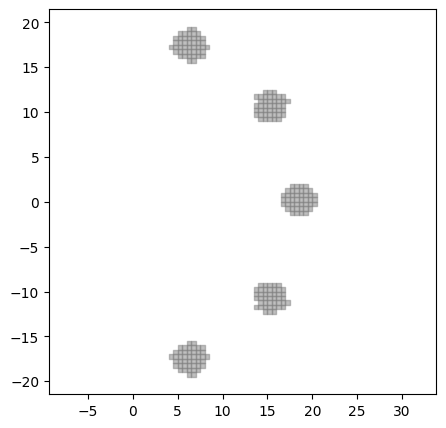

--------------------------------------------------
label: VentHole Chromosome_36: ['CircleShape_147', 'CornerTransformation_74']
predict: (0.29332843520032514, 373.9979817, 457.31508359999987)
biased_fitness: 0.6308085346960985, fitness: 0.660150321496749
shape parameter:
parameter_list: [ r: 1.9325968987232311, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 7.176097969769296, phi: 0.40092561775804525, rot_count: 4.0, ]


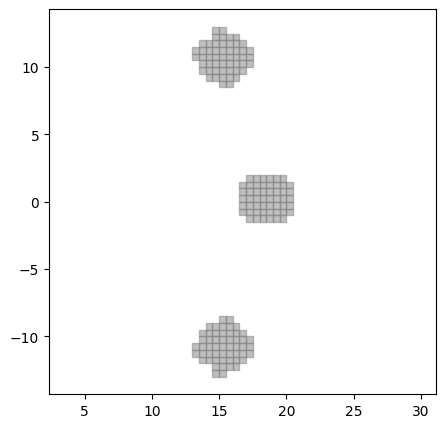

--------------------------------------------------
label: VentHole Chromosome_80: ['CircleShape_163', 'CornerTransformation_74']
predict: (0.29426974443408405, 373.2534394999999, 454.6901884999997)
biased_fitness: 0.6337351152909931, fitness: 0.6675844156591615
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


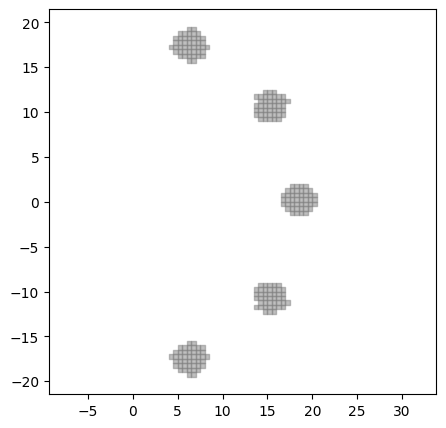

--------------------------------------------------
label: VentHole Chromosome_169: ['CircleShape_169', 'CornerTransformation_36']
predict: (0.29413493945639635, 373.7068815999999, 456.5288332999998)
biased_fitness: 0.6257309853232449, fitness: 0.6574720309360378
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 7.176097969769296, phi: 0.40092561775804525, rot_count: 4.0, ]


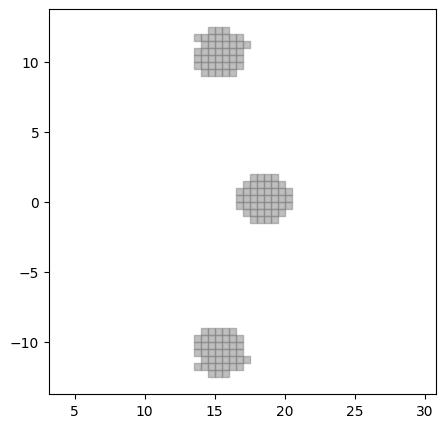

--------------------------------------------------
label: VentHole Chromosome_119: ['CircleShape_110', 'CornerTransformation_66']
predict: (0.2940208726293687, 373.2862447999999, 457.0981575999999)
biased_fitness: 0.6269256740475762, fitness: 0.6578692617063137
shape parameter:
parameter_list: [ r: 1.553240706301616, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


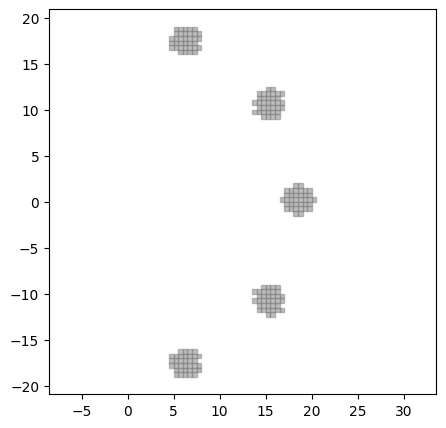

--------------------------------------------------
label: VentHole Chromosome_110: ['CircleShape_119', 'CornerTransformation_66']
predict: (0.2933734402191499, 373.7027487999999, 456.36690799999997)
biased_fitness: 0.6355373413702018, fitness: 0.6659173138085016
shape parameter:
parameter_list: [ r: 1.553240706301616, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


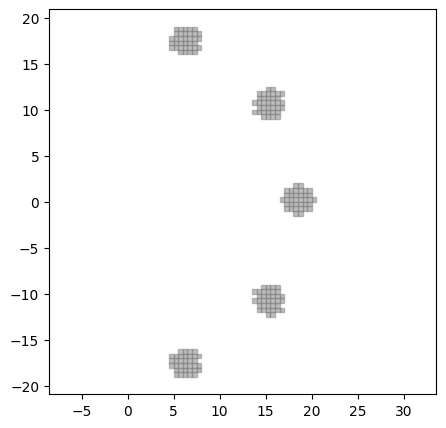

--------------------------------------------------
label: VentHole Chromosome_110: ['CircleShape_74', 'CornerTransformation_66']
predict: (0.29388927626359096, 373.1256555, 454.9787545)
biased_fitness: 0.6377853893369085, fitness: 0.6705851873640905
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 2.0380567088819577, phi: 0.4554539997184178, rot_count: 2.0, ]


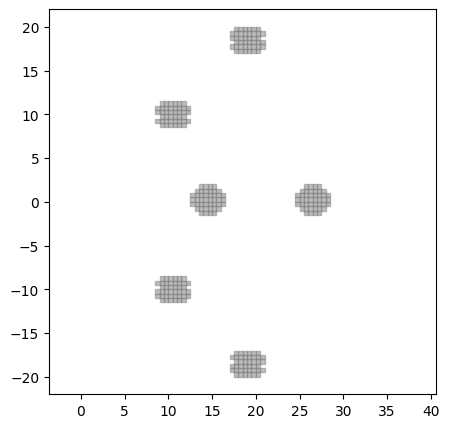

--------------------------------------------------
label: VentHole Chromosome_66: ['CircleShape_110', 'CornerTransformation_110']
predict: (0.29336939391381844, 373.4405789, 457.15976329999984)
biased_fitness: 0.6337253253341792, fitness: 0.6633043498618163
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 2.0380567088819577, phi: 0.4554539997184178, rot_count: 2.0, ]


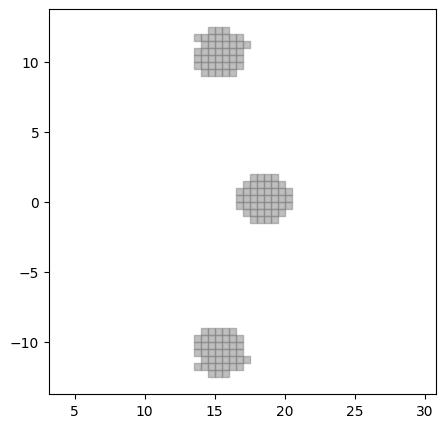

--------------------------------------------------
label: VentHole Chromosome_36: ['CircleShape_66', 'CornerTransformation_169']
predict: (0.29434311809490366, 373.40894919999977, 454.94866570000005)
biased_fitness: 0.631043174061157, fitness: 0.6647807445509643
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


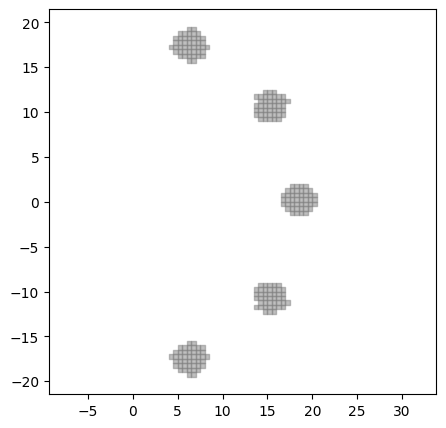

--------------------------------------------------
label: VentHole Chromosome_80: ['CircleShape_36', 'CornerTransformation_66']
predict: (0.2931516173549358, 373.8038568, 456.85730679999983)
biased_fitness: 0.6357320805407711, fitness: 0.6651780084506429
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 7.176097969769296, phi: 0.40092561775804525, rot_count: 4.0, ]


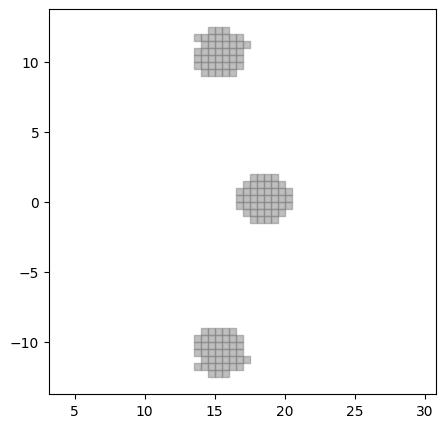

--------------------------------------------------
label: VentHole Chromosome_36: ['CircleShape_80', 'CornerTransformation_119']
predict: (0.2935117869106374, 373.8838283999999, 457.2939884)
biased_fitness: 0.6292634614723516, fitness: 0.6589930468936264
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


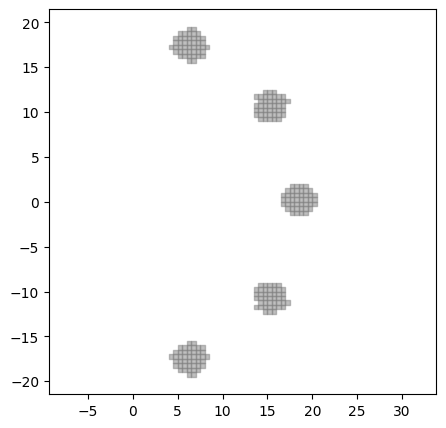

--------------------------------------------------
label: VentHole Chromosome_36: ['CircleShape_74', 'CornerTransformation_175']
predict: (0.2932516323471739, 373.5356752999999, 456.4216951999998)
biased_fitness: 0.6376152545339144, fitness: 0.6676968240282624
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


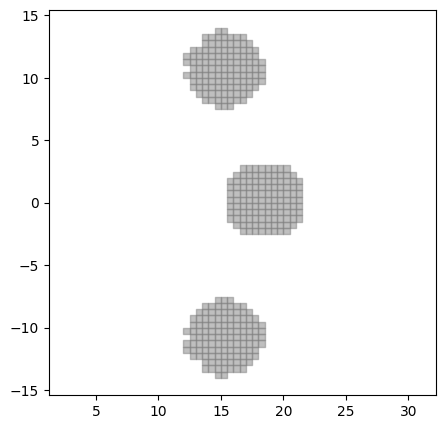

--------------------------------------------------
label: VentHole Chromosome_36: ['CircleShape_36', 'CornerTransformation_169']
predict: (0.29368137145603246, 374.0210664, 458.0217603999999)
biased_fitness: 0.6236311689276108, fitness: 0.6529721514396759
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 7.176097969769296, phi: 0.40092561775804525, rot_count: 4.0, ]


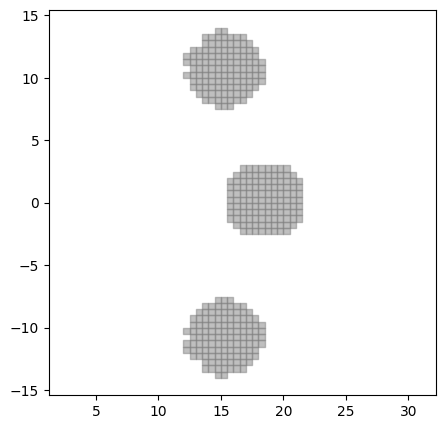

--------------------------------------------------
label: VentHole Chromosome_147: ['CircleShape_74', 'CornerTransformation_36']
predict: (0.29447472606312064, 373.34807019999994, 454.2741191999999)
biased_fitness: 0.6324664594425529, fitness: 0.6671417923687942
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


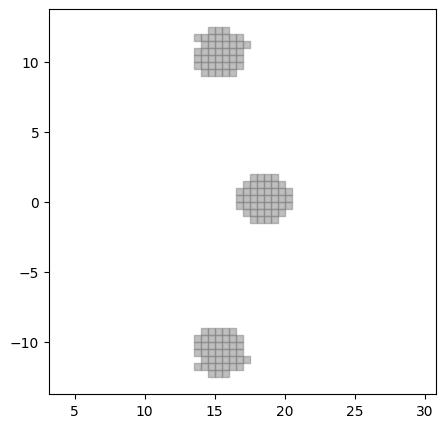

--------------------------------------------------
label: VentHole Chromosome_119: ['CircleShape_80', 'CornerTransformation_175']
predict: (0.2931516173549358, 373.8038568, 456.85730679999983)
biased_fitness: 0.6357320805407711, fitness: 0.6651780084506429
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


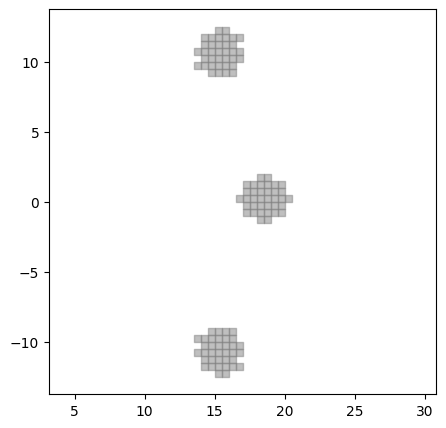

--------------------------------------------------
label: VentHole Chromosome_66: ['CircleShape_119', 'CornerTransformation_66']
predict: (0.2935117869106374, 373.8838283999999, 457.2939884)
biased_fitness: 0.6292634614723516, fitness: 0.6589930468936264
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


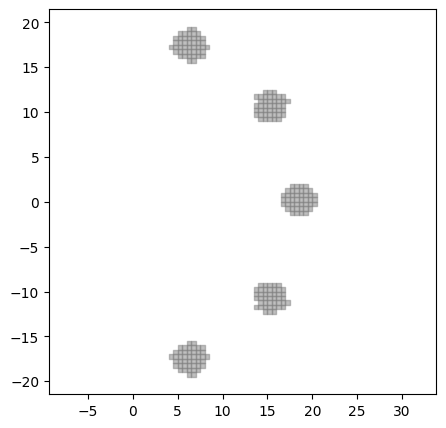

--------------------------------------------------
label: VentHole Chromosome_110: ['CircleShape_169', 'CornerTransformation_66']
predict: (0.2941348644037005, 373.4770025999998, 453.38008719999976)
biased_fitness: 0.6394762653555955, fitness: 0.6743659069629968
shape parameter:
parameter_list: [ r: 1.553240706301616, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


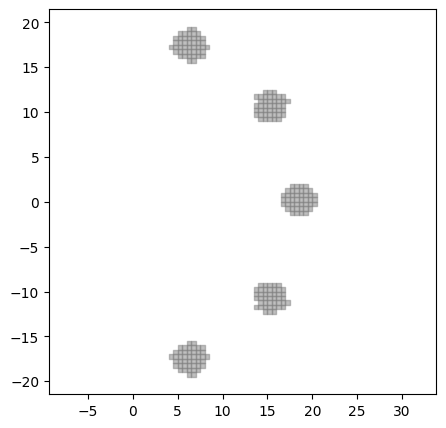

--------------------------------------------------
label: VentHole Chromosome_163: ['CircleShape_66', 'CornerTransformation_66']
predict: (0.294202660118309, 373.85503549999993, 458.99215119999985)
biased_fitness: 0.6143242962802931, fitness: 0.6437374653169112
shape parameter:
parameter_list: [ r: 2.9900291032807957, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 7.176097969769296, phi: 0.40092561775804525, rot_count: 4.0, ]


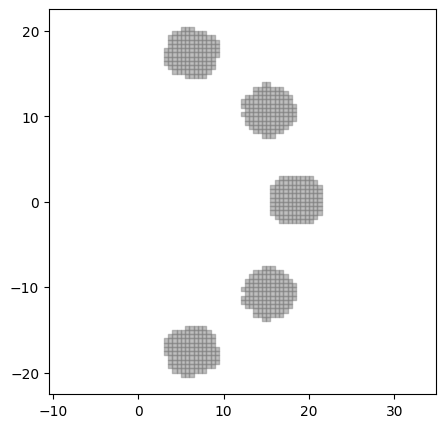

--------------------------------------------------
label: VentHole Chromosome_110: ['CircleShape_197', 'CornerTransformation_36']
predict: (0.2931516173549358, 373.8038568, 456.85730679999983)
biased_fitness: 0.6357320805407711, fitness: 0.6651780084506429
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


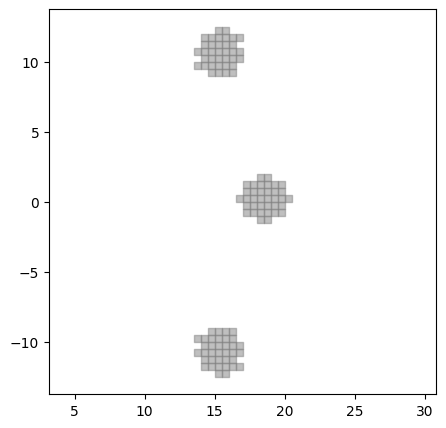

--------------------------------------------------
label: VentHole Chromosome_80: ['CircleShape_74', 'CornerTransformation_80']
predict: (0.2935991585561768, 373.90455410000004, 457.6418842)
biased_fitness: 0.6267197900258782, fitness: 0.6562762229382318
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 2.0, ]


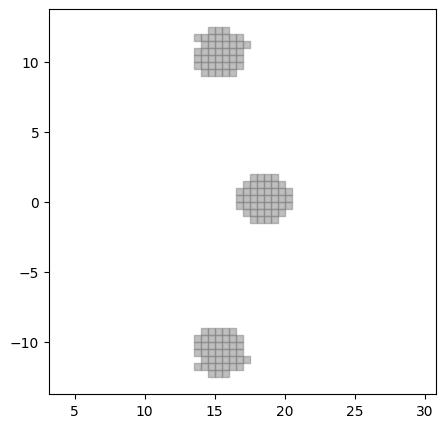

--------------------------------------------------
label: VentHole Chromosome_64: ['CircleShape_66', 'CornerTransformation_64']
predict: (0.2943604540592899, 373.48019780000004, 458.2724775999999)
biased_fitness: 0.6171836518885213, fitness: 0.6476320824071012
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


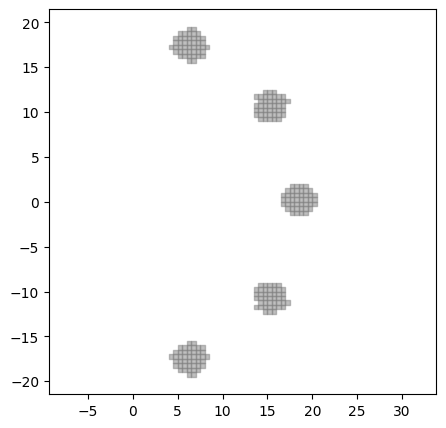

--------------------------------------------------
label: VentHole Chromosome_66: ['CircleShape_175', 'CornerTransformation_187']
predict: (0.293156205333581, 373.5681343999999, 456.25127449999985)
biased_fitness: 0.6392797659970291, fitness: 0.6693409021641912
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


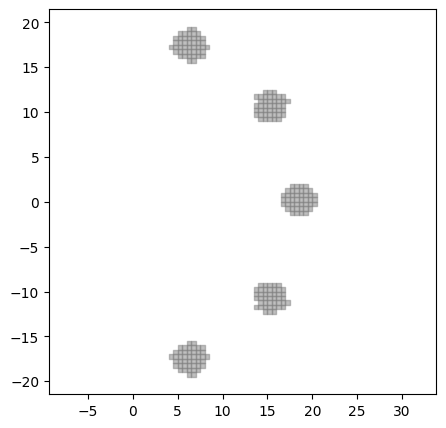

--------------------------------------------------
label: VentHole Chromosome_110: ['CircleShape_147', 'CornerTransformation_110']
predict: (0.2931516173549358, 373.8038568, 456.85730679999983)
biased_fitness: 0.6357320805407711, fitness: 0.6651780084506429
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


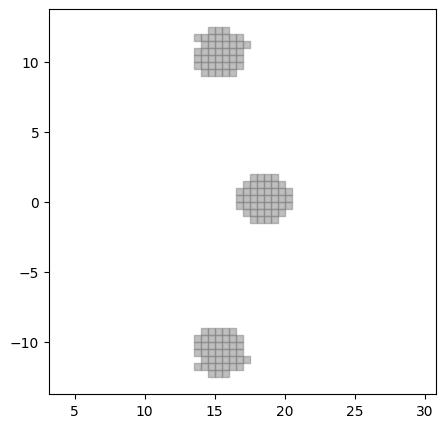

--------------------------------------------------
label: VentHole Chromosome_25: ['CircleShape_33', 'CornerTransformation_110']
predict: (0.29356750954843314, 373.5516218000001, 456.8861357999999)
biased_fitness: 0.6318872332188021, fitness: 0.6621361165156685
shape parameter:
parameter_list: [ r: 1.7120827310808377, ]
pattern parameter:
parameter_list: [ di: 13.437485597671579, dx: 3.2319107943605037, phi: 0.40092561775804525, rot_count: 4.0, ]


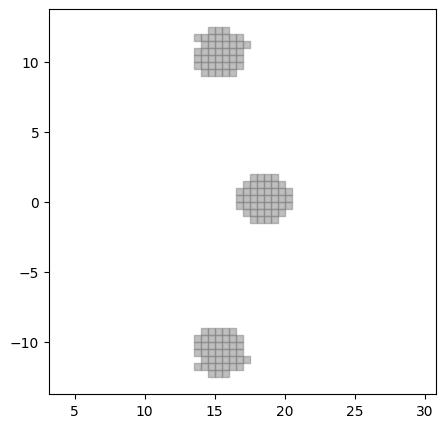

In [4]:
from src.grid.visualize_points import visualize_points


for pop in suite.unique_population:
    print("-" * 50)
    print(f"label: {pop.label}")
    print(f"predict: {pop.fitness_pure_result}")
    print(f"biased_fitness: {pop.biased_fitness}, fitness: {pop.fitness}")

    shape, pattern = pop.gene_tuple
    print("shape parameter:")
    shape.print_parameter_info()
    print("pattern parameter:")
    pattern.print_parameter_info()

    visualize_points(
        pop.pattern.pattern_matrix,
        pop.pattern.pattern_unit.grid.k,
        fig_size=(5, 5),
    )